<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Process-data" data-toc-modified-id="Process-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Process data</a></span><ul class="toc-item"><li><span><a href="#Spatial-average" data-toc-modified-id="Spatial-average-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Spatial average</a></span></li></ul></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualization</a></span><ul class="toc-item"><li><span><a href="#Meridional-and-zonal-components-together" data-toc-modified-id="Meridional-and-zonal-components-together-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Meridional and zonal components together</a></span></li><li><span><a href="#Meridional-component-only" data-toc-modified-id="Meridional-component-only-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Meridional component only</a></span></li></ul></li></ul></div>

# Import libraries

In [1]:
import xarray as xr
import xarray.ufuncs as xrf
from averaging import xarray_average
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xclim as xc

In [2]:
%reload_ext watermark
%watermark --iversions -v -m

numpy   1.17.3
seaborn 0.9.0
xarray  0.14.1
pandas  1.0.1
CPython 3.6.9
IPython 7.1.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-96-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


# Load data

In [15]:
var_name = 'accelogwn'

In [3]:
inpath = '/mnt/4data/CMAM/0A.daily/'
infiles = f'{inpath}{var_name}/{var_name}_6hrPlev_CMAM_CMAM30-SD_r1i1p1_*18.nc'
ds = xr.open_mfdataset(infiles, concat_dim='time', combine = 'by_coords', parallel = True)
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 48, lon: 96, plev: 63, time: 46720)
Coordinates:
  * lon        (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * lat        (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 8e+04 ... 0.2 0.15 0.1 0.07
  * time       (time) object 1979-01-01 00:00:00 ... 2010-12-31 18:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1460, 2), meta=np.ndarray>
    plev_bnds  (time, plev, bnds) float64 dask.array<chunksize=(1460, 63, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(1460, 48, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(1460, 96, 2), meta=np.ndarray>
    accelogwn  (time, plev, lat, lon) float32 dask.array<chunksize=(1460, 63, 48, 96), meta=np.ndarray>
Attributes:
    institution:            CCCma (Canadian Centre for Climate Modelling and ...
    institute_id:           CCCma
    experiment_id:          CMAM30-SD
    source:                 CMAM 2013
    model_id:               CMAM
    forcing:                N/A
    parent_experiment_id:   N/A
    parent_experiment_rip:  N/A
    branch_time:            0.0
    contact:                cccma_info@ec.gc.ca
    comment:                The CMAM30 team gratefully acknowledges the Canad...
    references:             http://www.cccma.ec.gc.ca/models
    initialization_method:  1
    physics_version:        1
    tracking_id:            bc122c60-a2eb-4cdb-b934-5124c6772033
    CCCma_runid:            cmam20_abc001
    CCCma_data_licence:     1) GRANT OF LICENCE - The Government of Canada (E...
    product:                output
    experiment:             CMAM 30-year specified dynamics run
    frequency:              6hr
    creation_date:          2013-05-27T23:53:57Z
    history:                2013-05-27T23:53:57Z CMOR rewrote data to comply ...
    Conventions:            CF-1.4
    project_id:             CMAM30
    table_id:               Table 6hrPlev (10 April 2013) 303ca12ce2a31d5584f...
    title:                  CMAM model output prepared for CMAM30 CMAM 30-yea...
    parent_experiment:      N/A
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.2

# Process data

In [12]:
time_mask = (ds.time.dt.month == 12) | (ds.time.dt.month == 1) | (ds.time.dt.month == 2)
ds_sel = ds[var_name].sel(time = time_mask, plev = 7000)
ds_sel = ds_sel.resample(time = '1D').mean('time').load()

sel_dict_ea = dict(lon =slice(110,145), lat=slice(30,48)) 
sel_dict_hi = dict(lon =slice(70,102.5), lat=slice(20,40)) 
sel_dict_wa = dict(lon =slice(-125+360,-102.5+360), lat=slice(27.5,52)) 

sel_dict_ls = {'Himalayas': sel_dict_hi, \
               'West America': sel_dict_wa, \
               'East Asia': sel_dict_ea}
weights = xrf.cos(xrf.deg2rad(ds_sel.lat))

In [13]:
ds_sel#.resample(time = '1D').mean('time')

<xarray.DataArray 'accelogwn' (time: 11680, lat: 48, lon: 96)>
array([[[ 2.2820075e-07,  1.7237670e-07,  2.2476610e-07, ...,
          2.0871891e-08,  5.3706735e-08,  1.6687891e-07],
        [ 4.9990467e-07,  9.0303661e-07,  8.0997467e-07, ...,
          2.7404079e-07,  9.4123033e-07,  1.7986617e-06],
        [ 1.4095470e-07,  3.0932753e-07,  1.5927787e-07, ...,
          8.2788823e-08,  2.4745464e-07,  1.1475254e-07],
        ...,
        [-5.4866498e-09,  9.9014272e-09,  3.1816526e-07, ...,
          3.7391653e-14,  3.7391653e-14,  3.7391653e-14],
        [ 3.7391653e-14,  3.7391653e-14,  3.7391653e-14, ...,
          3.7391653e-14,  3.7391653e-14,  3.7391653e-14],
        [ 3.7391653e-14,  3.7391653e-14,  3.7391653e-14, ...,
          3.7391653e-14,  3.7391653e-14,  3.7391653e-14]],

       [[ 5.8412922e-07,  4.9615170e-07,  5.5010315e-07, ...,
          5.5014013e-08,  1.2216869e-07,  4.4100787e-07],
        [ 1.1130800e-07,  3.2509938e-08,  7.9702431e-08, ...,
          4.0093141e-08,  8.5367176e-08,  6.1114342e-08],
        [ 4.3343899e-08,  1.3571875e-07,  1.6334330e-07, ...,
         -8.9398127e-15, -8.9398127e-15, -8.9398127e-15],
        ...,
        [ 2.4721546e-14,  2.2425416e-08,  2.4721546e-14, ...,
          4.2582491e-07,  5.5933154e-11,  3.2202237e-11],
        [ 2.4721546e-14,  2.4721546e-14,  2.4721546e-14, ...,
          2.4721546e-14,  4.5281126e-09,  3.4304895e-10],
        [ 2.4721546e-14,  2.4721546e-14,  2.4721546e-14, ...,
          2.4721546e-14,  2.4721546e-14,  2.4721546e-14]],

       [[ 5.6582721e-08,  5.6006026e-08,  1.3524247e-07, ...,
          6.8411936e-08,  3.1539678e-08,  1.5547753e-08],
        [ 1.7679049e-08,  1.2308277e-08,  4.7914114e-08, ...,
          2.5059044e-10,  1.6550533e-09,  3.9506465e-10],
        [ 1.8223456e-07,  3.4573486e-07,  6.6030857e-08, ...,
          2.0853793e-08,  1.0231162e-07,  6.6652660e-08],
        ...,
        [ 5.1740859e-14,  5.9454212e-08, -5.1493735e-14, ...,
          2.3100100e-08,  1.9548596e-08,  3.8046549e-11],
        [-1.4394576e-14, -1.4394576e-14, -1.4394576e-14, ...,
         -1.4394576e-14, -1.4394576e-14, -1.4394576e-14],
        [-1.4394576e-14, -1.4394576e-14, -1.4394576e-14, ...,
         -1.4394576e-14, -1.4394576e-14, -1.4394576e-14]],

       ...,

       [[-7.9900699e-14, -7.9900699e-14, -7.9900699e-14, ...,
         -7.9900699e-14, -7.9900699e-14, -7.9900699e-14],
        [ 5.2627733e-09,  5.8057936e-09,  9.5810087e-08, ...,
         -7.9900699e-14, -7.9900699e-14, -7.9900699e-14],
        [ 6.1124226e-08,  1.9384451e-07,  2.2775976e-07, ...,
         -7.9900699e-14,  1.6873566e-08,  2.0152529e-11],
        ...,
        [-1.8954177e-14, -1.8954177e-14, -1.8954177e-14, ...,
         -1.8954177e-14, -1.8954177e-14, -1.8954177e-14],
        [-1.8954177e-14, -1.8954177e-14, -1.8954177e-14, ...,
         -1.8954177e-14, -1.8954177e-14, -1.8954177e-14],
        [-1.8954177e-14, -1.8954177e-14, -1.8954177e-14, ...,
         -1.8954177e-14, -1.8954177e-14, -1.8954177e-14]],

       [[ 8.4172883e-14,  8.4172883e-14,  8.4172883e-14, ...,
          8.4172883e-14,  8.4172883e-14,  8.4172883e-14],
        [ 3.1083520e-08,  1.8426405e-08,  3.3105695e-07, ...,
          8.4172883e-14,  8.4172883e-14,  8.4172883e-14],
        [ 2.0985009e-07,  5.6425063e-07,  4.7628276e-07, ...,
          8.4172883e-14,  6.4802258e-08,  7.3497097e-10],
        ...,
        [ 8.4172883e-14,  8.4172883e-14,  8.4172883e-14, ...,
          1.2431730e-08,  8.4172883e-14,  8.4172883e-14],
        [ 8.4172883e-14,  8.4172883e-14,  8.4172883e-14, ...,
          8.4172883e-14,  8.4172883e-14,  8.4172883e-14],
        [ 8.4172883e-14,  8.4172883e-14,  8.4172883e-14, ...,
          8.4172883e-14,  8.4172883e-14,  8.4172883e-14]],

       [[ 2.9070903e-14,  2.9070903e-14,  2.9070903e-14, ...,
         -1.9500131e-08, -2.7725728e-09,  2.9070903e-14],
        [ 5.9755769e-09,  1.3630184e-08,  4.1049795e-08, ...,
          2.9070903e-14,  2.9070903e-14,  2.9070903e-14],
        [

In [16]:
ts_ls = []
g_ls = []
for hs_name in sel_dict_ls.keys():
    print(hs_name)
    sel_dict = sel_dict_ls[hs_name]
    ds_sel_hs = ds_sel.sel(**sel_dict)
    #ds_sel_hs = xarray_average(ds_sel_hs, dim = ['lat', 'lon'], weights = weights)#.load()
    #ds_sel_hs.name = 'accelogw'
    ts = ds_sel_hs.dropna('time').to_series().reset_index()
    #sys.exit()
    g_ls += [hs_name]*ts.shape[0]    
    ts_ls.append(ts)

df = pd.concat(ts_ls)
df['g'] = g_ls
df[var_name] = df[var_name]*24*3600
df.head()

Himalayas
West America
East Asia


,time,lat,lon,accelogwn,g
0,1979-01-01 00:00:00,20.411238,71.25,3.230639e-09,Himalayas
1,1979-01-01 00:00:00,20.411238,75.00,3.230639e-09,Himalayas
2,1979-01-01 00:00:00,20.411238,78.75,3.230639e-09,Himalayas
3,1979-01-01 00:00:00,20.411238,82.50,4.196809e-01,Himalayas
4,1979-01-01 00:00:00,20.411238,86.25,8.470623e-03,Himalayas


## Spatial average

In [17]:
ts_ls = []
g_ls = []
for hs_name in sel_dict_ls.keys():
    sel_dict = sel_dict_ls[hs_name]
    ds_sel_hs = ds_sel.sel(**sel_dict)
    ds_sel_hs = xarray_average(ds_sel_hs, dim = ['lat', 'lon'], weights = weights)#.load()
    ds_sel_hs.name = var_name
    ts = ds_sel_hs.dropna('time').to_series().reset_index()
    g_ls += [hs_name]*ts.shape[0]    
    ts_ls.append(ts)

df2 = pd.concat(ts_ls)
df2['g'] = g_ls
df2[var_name] = df2[var_name]*24*3600
df2.head()

,time,accelogwn,g
0,1979-01-01 00:00:00,-0.088828,Himalayas
1,1979-01-02 00:00:00,-0.145551,Himalayas
2,1979-01-03 00:00:00,-0.038588,Himalayas
3,1979-01-04 00:00:00,-0.049557,Himalayas
4,1979-01-05 00:00:00,0.358900,Himalayas


In [56]:
inpath = '/mnt/4data/CMAM/0A.daily/'
ds_zonal = xr.open_dataset(f'{inpath}accelogw/accelogw_daily_CMAM_CMAM30-SD_r1i1p1_19790101-20101231_70hPa.nc')
time_mask = (ds_zonal.time.dt.month == 12) | (ds_zonal.time.dt.month == 1) | (ds_zonal.time.dt.month == 2)
ds_sel_zonal = ds_zonal['accelogw'].sel(time = time_mask)
weights = xrf.cos(xrf.deg2rad(ds_sel_zonal.lat))

In [57]:
ts_ls = []
g_ls = []
for hs_name in sel_dict_ls.keys():
    print(hs_name)
    sel_dict = sel_dict_ls[hs_name]
    ds_sel_hs_zonal = ds_sel_zonal.sel(**sel_dict)
    ts = ds_sel_hs_zonal.dropna('time').to_series().reset_index()
    #sys.exit()
    g_ls += [hs_name]*ts.shape[0]    
    ts_ls.append(ts)

df_zonal = pd.concat(ts_ls)
df_zonal['g'] = g_ls
df_zonal['accelogw'] = df_zonal['accelogw']*24*3600
df_zonal.head()

Himalayas
West America
East Asia


,time,lat,lon,accelogw,g
0,1979-01-01,20.411238,71.25,5.009432e-09,Himalayas
1,1979-01-01,20.411238,75.00,5.009432e-09,Himalayas
2,1979-01-01,20.411238,78.75,5.009432e-09,Himalayas
3,1979-01-01,20.411238,82.50,-2.866767e-01,Himalayas
4,1979-01-01,20.411238,86.25,-5.888247e-03,Himalayas


# Visualization

## Meridional and zonal components together

Himalayas 0.5554687690286121
West America 0.46725125923226224
East Asia -0.6054369687347316


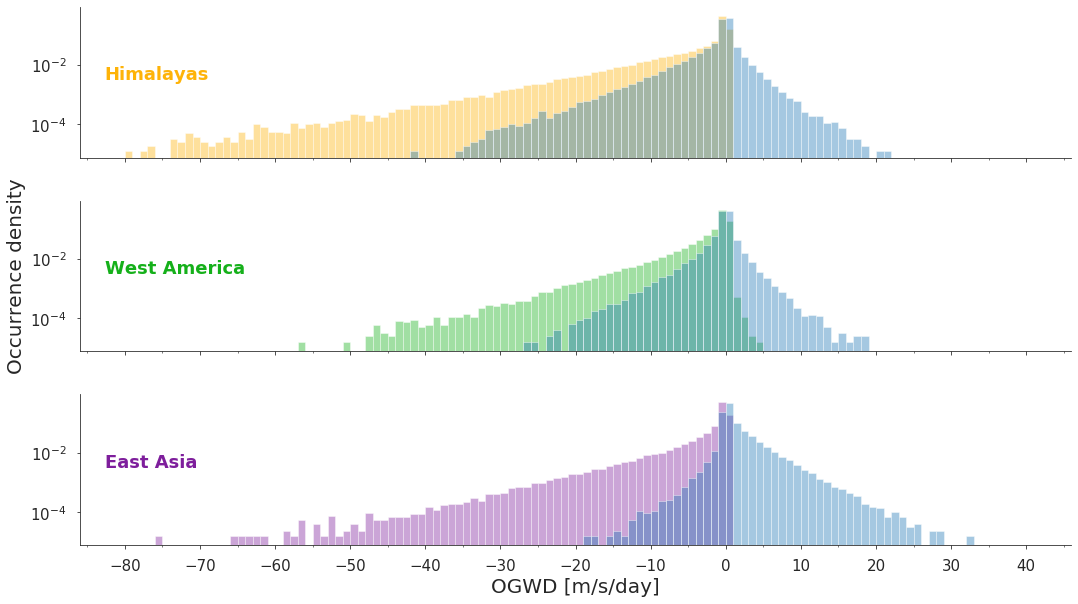

In [67]:
bins = np.arange(-80,41)
xticks = np.arange(-80,45,10)
g = sns.FacetGrid(df_zonal, row="g", hue="g", aspect=5, palette=pal)
g.map(sns.distplot, 'accelogw', norm_hist = True, kde=False, rug=False, bins = bins)

dist_name = 'laplace'#'cauchy'#'norm'
for i, hs_name in enumerate(sel_dict_ls.keys()):
    ax = g.axes[i][0]
    
    arr = df[var_name][df['g'] == hs_name]
    arr2 = df_zonal['accelogw'][df['g'] == hs_name]
    print(hs_name, np.corrcoef(arr, arr2)[0][1])
    arr.index.name = 'time'
    arr = arr.to_xarray()
    sns.distplot(arr, norm_hist = True, kde=False, rug=False, \
             bins = bins, ax = ax)
    """
    ind = xc.indices.generic.fit(arr, dist = dist_name).compute()
    dist = xc.indices.generic.get_dist(dist_name)
    mean, var, skew, kurt = dist.stats(*ind.values, moments='mvsk')
    textstr = '\n'.join((
        'Mean=%.2f' % (mean, ),
        'Variance=%.2f' % (var, ),
        'Skewness=%.2f' % (skew, ),
        'Kurtosis=%.2f' % (kurt, )))
    ax.text(0.7, 0.8, textstr, fontsize=14, verticalalignment='top', \
            color = 'C0', transform=ax.transAxes)  
    
    
    

    dist = xc.indices.generic.get_dist(dist_name)
    ax.plot(bins,dist.pdf(bins, *ind.values), color = 'C0')
    
    arr = df[var_name][df['g'] == hs_name]
    arr.index.name = 'time'
    arr = arr.to_xarray()

    ind = xc.indices.generic.fit(arr, dist = dist_name).compute()
    dist = xc.indices.generic.get_dist(dist_name)
    ax.plot(bins, dist.pdf(bins, *ind.values), color = pal[i])    
    mean, var, skew, kurt = dist.stats(*ind.values, moments='mvsk')
    textstr = '\n'.join((
        'Mean=%.2f' % (mean, ),
        'Variance=%.2f' % (var, ),
        'Skewness=%.2f' % (skew, ),
        'Kurtosis=%.2f' % (kurt, )))
    ax.text(0.2, 0.8, textstr, fontsize=14, verticalalignment='top', \
            color = pal[i], transform=ax.transAxes)  
    """
    
    ax.tick_params(axis="y",direction="out", pad=10, labelsize = 15)
    ax.tick_params(axis="x",direction="out", pad=10, labelsize = 15)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
    ax.set_ylim(0,0.9)
    ax.set_yscale('log')
    
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.025, .55, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 'accelogw')
g.set(xticks=xticks)
# Remove axes details that don't play well with overlap
g.set_titles("")
#g.set(yscale="log")
g.axes[nh-1][0].set_xlabel('OGWD [m/s/day]', fontsize = 20)
g.axes[nh-2][0].set_ylabel('Occurrence density', fontsize = 20)
plt.savefig('merOGWD_distribution_hotspots_DJFonly.pdf', bbox_inches='tight') 

## Meridional component only

Text(1.3039843749999989, 0.5, 'Occurrence density')

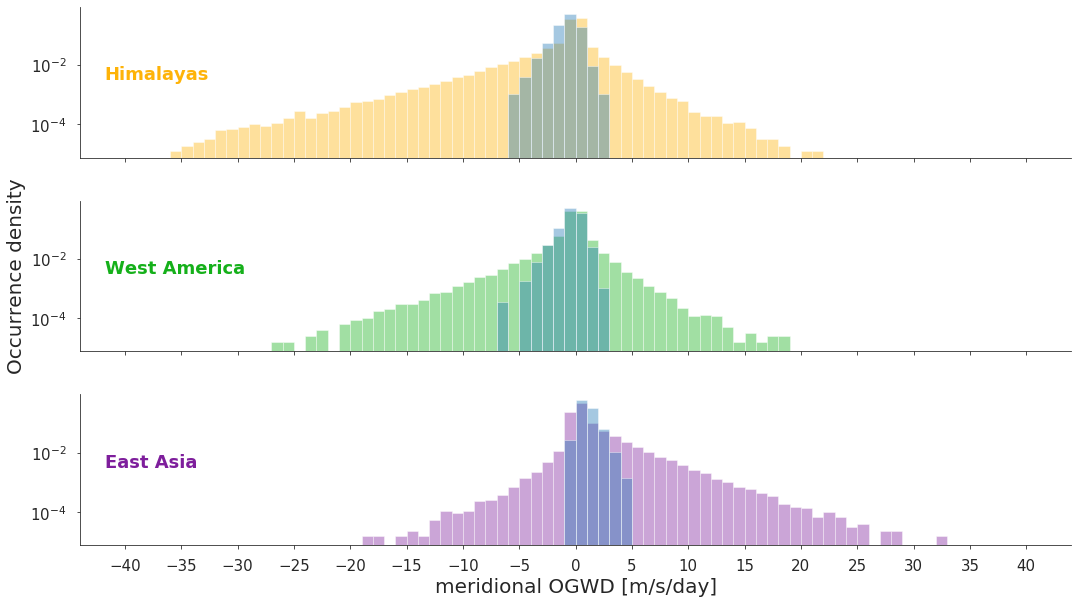

In [54]:
bins = np.arange(-40,41)
xticks = np.arange(-40,45,5)
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, palette=pal)
g.map(sns.distplot, var_name, norm_hist = True, kde=False, rug=False, bins = bins)

dist_name = 'laplace'#'cauchy'#'norm'
for i, hs_name in enumerate(sel_dict_ls.keys()):
    ax = g.axes[i][0]
    
    arr = df2[var_name][df2['g'] == hs_name]
    arr.index.name = 'time'
    arr = arr.to_xarray()
    sns.distplot(arr, norm_hist = True, kde=False, rug=False, \
             bins = bins, ax = ax)
    """
    ind = xc.indices.generic.fit(arr, dist = dist_name).compute()
    dist = xc.indices.generic.get_dist(dist_name)
    mean, var, skew, kurt = dist.stats(*ind.values, moments='mvsk')
    textstr = '\n'.join((
        'Mean=%.2f' % (mean, ),
        'Variance=%.2f' % (var, ),
        'Skewness=%.2f' % (skew, ),
        'Kurtosis=%.2f' % (kurt, )))
    ax.text(0.7, 0.8, textstr, fontsize=14, verticalalignment='top', \
            color = 'C0', transform=ax.transAxes)  
    
    
    

    dist = xc.indices.generic.get_dist(dist_name)
    ax.plot(bins,dist.pdf(bins, *ind.values), color = 'C0')
    
    arr = df[var_name][df['g'] == hs_name]
    arr.index.name = 'time'
    arr = arr.to_xarray()

    ind = xc.indices.generic.fit(arr, dist = dist_name).compute()
    dist = xc.indices.generic.get_dist(dist_name)
    ax.plot(bins, dist.pdf(bins, *ind.values), color = pal[i])    
    mean, var, skew, kurt = dist.stats(*ind.values, moments='mvsk')
    textstr = '\n'.join((
        'Mean=%.2f' % (mean, ),
        'Variance=%.2f' % (var, ),
        'Skewness=%.2f' % (skew, ),
        'Kurtosis=%.2f' % (kurt, )))
    ax.text(0.2, 0.8, textstr, fontsize=14, verticalalignment='top', \
            color = pal[i], transform=ax.transAxes)  
    """
    
    ax.tick_params(axis="y",direction="out", pad=10, labelsize = 15)
    ax.tick_params(axis="x",direction="out", pad=10, labelsize = 15)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
    ax.set_ylim(0,0.9)
    ax.set_yscale('log')
    
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.025, .55, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, var_name)
g.set(xticks=xticks)
# Remove axes details that don't play well with overlap
g.set_titles("")
#g.set(yscale="log")
g.axes[nh-1][0].set_xlabel('meridional OGWD [m/s/day]', fontsize = 20)
g.axes[nh-2][0].set_ylabel('Occurrence density', fontsize = 20)